## Setup Kaggle

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
## load kaggle.json file from local drive
from google.colab import files
uploaded = files.upload()

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

### Load Capital A-Z Alphabets Dataset

In [2]:
! kaggle datasets download sachinpatel21/az-handwritten-alphabets-in-csv-format

 99%|███████████████████████████████████████▋| 183M/185M [00:08<00:00, 24.4MB/s]
100%|████████████████████████████████████████| 185M/185M [00:08<00:00, 23.3MB/s]


In [3]:
! unzip az-handwritten-alphabets-in-csv-format.zip

Archive:  az-handwritten-alphabets-in-csv-format.zip
replace A_Z Handwritten Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### Load MNIST Dataset

In [1]:
! kaggle competitions download -c digit-recognizer

/bin/bash: kaggle: command not found


In [ ]:
! unzip digit-recognizer.zip

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


### For paperspace gradient

In [ ]:
! apt update && apt upgrade -y

In [ ]:
! apt install -y libgl1-mesa-glx

In [ ]:
! pip install opencv-python

## Import libraries

In [8]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = "darkgrid")

import gc

import keras
#from keras.utils.np_utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

import cv2



from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Define the data

In [20]:
df_num = pd.read_csv("train.csv") # MNIST train data
df_alph = pd.read_csv("A_Z Handwritten Data.csv") # Character data
df_alph["0"] += 10

### Shape of the dataframe -

In [ ]:
df_num.head()

In [ ]:
df_alph.head()

In [10]:
df_num.shape, df_alph.shape

((42000, 785), (372450, 785))

### Make the column names similar and concatenate datasets-

In [21]:
pixel_array = ["Label"]
for i in range(1, 785):
    pixel_array.append(f"pixel_{i}")
df_num.columns = pixel_array
df_alph.columns = pixel_array
del pixel_array
gc.collect()

df = pd.concat([df_num, df_alph], axis = 0)
df.shape

(414450, 785)

Split the data into its labels -

In [22]:
X = df.drop('Label',axis = 1)
y = df['Label']

### Set seed for same work -

In [23]:
SEED = 42
np.random.seed(SEED)

## EDA


In [24]:
## Word labels
word_dict = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'6',6:'6',7:'7',8:'8',9:'9',
             10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',16:'G',17:'H',18:'I',19:'J',
             20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',
             30:'U',31:'V',32:'W',33:'X', 34:'Y',35:'Z'}

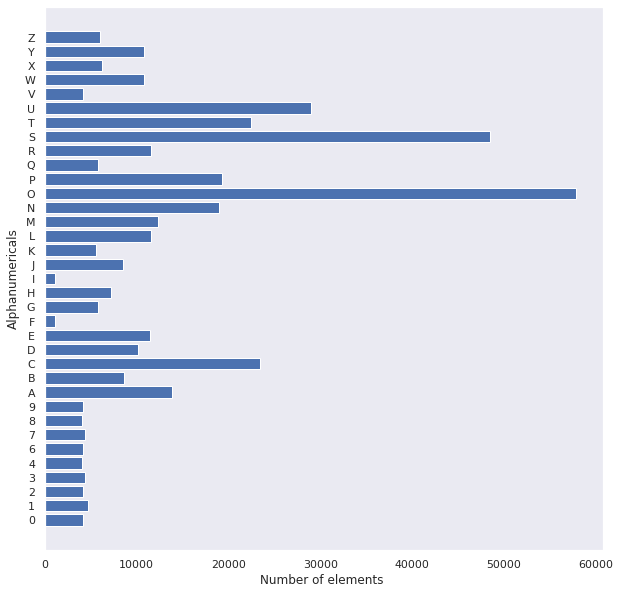

In [25]:
## Plot distribution
y_int = np.int0(y)
count = np.zeros(36, dtype='int')
for i in y_int:
    count[i] +=1

alphabets = []
for i in word_dict.values():
    alphabets.append(i)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.barh(alphabets, count)

plt.xlabel("Number of elements ")
plt.ylabel("Alphanumericals")
plt.grid()
plt.show()

Maximum and minimum number of frequencies -

In [26]:
a, b = df.Label[df.Label == 24].value_counts().sum(), df.Label[df.Label == 18].value_counts().sum()
print(f"Maximum and Minimum frequency for any target value in the data: {a, b}")

Maximum and Minimum frequency for any target value in the data: (57825, 1120)


It is quite unbalanced.

### Shuffle the data

Split the data to get training, test and predicting data -

In [44]:
X_reshaped = X_reshaped.reshape(-1, 28, 28, 1)

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_int, test_size = 0.3, stratify = y)

#data_to_predict = X_test.reshape(-1, 28, 28)

Plot data to predict-

In [45]:
def plot_grid(pred = False):
    fig=plt.figure(figsize=(8, 8))
    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        index = np.random.randint(data_to_predict.shape[0])
        fig.add_subplot(rows, columns, i)
        plt.imshow(data_to_predict[index], cmap = plt.get_cmap("gray"))
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f"Label: {word_dict[test_y[index]]}")
        #plt.xlabel(f"Label: {test_y[index]}")
    plt.tight_layout()
    plt.show()

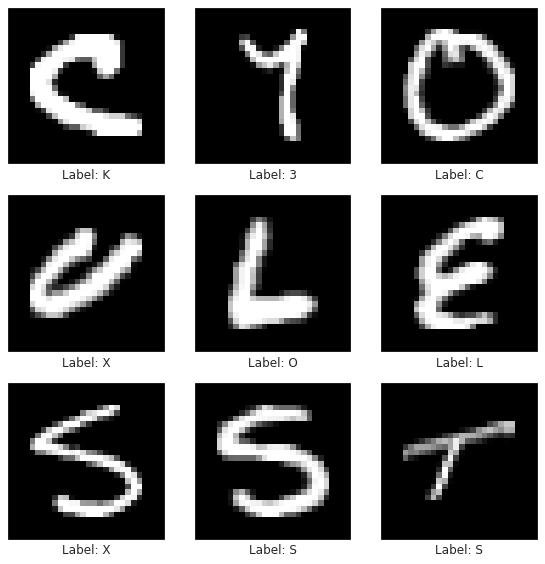

In [46]:
plot_grid()

## Standardizing Training Data and Categorizing Test Data

In [47]:
X_train_mean = X_train.mean().astype(np.float32)
X_train_std = X_train.std().astype(np.float32)
X_test_mean = X_test.mean().astype(np.float32)
X_test_std = X_test.std().astype(np.float32)

X_train = (X_train - X_train_mean)/X_train_std
X_test = (X_test - X_test_mean)/X_test_std

y_train = to_categorical(y_train, num_classes = 36)
y_test = to_categorical(y_test, num_classes = 36)

In [48]:
del X_train_mean, X_train_std, df_num, df_alph, X_reshaped, y_int, X, y, X_test_mean, X_test_std, data_to_predict, a, b
gc.collect()

17274

## Defining the Model

In [115]:
# create CNN model for layers
input_shape = (28, 28, 1)
num_classes = 36

model = Sequential()
model.add(Conv2D(64, kernel_size = (3, 3), activation = "relu", padding = "Same", input_shape = input_shape))
model.add(Conv2D(64, kernel_size = (3, 3), activation = "relu", padding = "Same"))
model.add(MaxPool2D(pool_size = (3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = (3, 3), activation = "relu", padding = "Same"))
model.add(Conv2D(128, kernel_size = (3, 3), activation = "relu", padding = "Same"))
model.add(MaxPool2D(pool_size = (3, 3)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(150, activation = "relu"))
model.add(Dropout(0.30))
model.add(Dense(36, activation = "softmax"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 9, 9, 64)          0         
                                                                 
 conv2d_12 (Conv2D)          (None, 9, 9, 128)         73856     
                                                                 
 conv2d_13 (Conv2D)          (None, 9, 9, 128)         147584    
                                                      

### Adam Optimizer 

In [116]:
optimizer = Adam(lr = .0001, beta_1 = .9, beta_2 = .999, epsilon = 1e-07, decay = 0, amsgrad = False)

### Compiling Model

In [117]:
# Compile the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["categorical_accuracy", tf.keras.metrics.AUC()])

# learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = .5, min_lr = .00001)

# EarlyStopping
es = EarlyStopping(monitor='val_categorical_accuracy', patience = 4)

### Batch and Epoch Size

In [142]:
epochs = 40
batch_size = 128

### Data Augmentation

In [143]:
# Data Augmentation
datagen = ImageDataGenerator(featurewise_center = False, samplewise_center = False, 
                            featurewise_std_normalization = False, samplewise_std_normalization = False,
                            zca_whitening = False, rotation_range = 10, zoom_range = .1, 
                            width_shift_range = .1, height_shift_range = .1, horizontal_flip = True, 
                            vertical_flip = False)
train_batches = datagen.flow(X_train, y_train, batch_size = batch_size)
val_batches = datagen.flow(X_test, y_test, batch_size = batch_size)

## Training + Cross Validation

In [144]:
# Fitting the model
history = model.fit_generator(generator = train_batches, steps_per_epoch = train_batches.n//batch_size, epochs=epochs, 
                    validation_data = val_batches, validation_steps = val_batches.n//batch_size,
                    callbacks = [learning_rate_reduction, es])

Epoch 1/40
2266/2266 [==============================] - 107s 47ms/step - loss: 0.2348 - categorical_accuracy: 0.9316 - auc_2: 0.9968 - val_loss: 0.1592 - val_categorical_accuracy: 0.9521 - val_auc_2: 0.9982 - lr: 1.0000e-04
Epoch 2/40
2266/2266 [==============================] - 108s 48ms/step - loss: 0.2278 - categorical_accuracy: 0.9336 - auc_2: 0.9969 - val_loss: 0.1572 - val_categorical_accuracy: 0.9524 - val_auc_2: 0.9981 - lr: 1.0000e-04
Epoch 3/40
2266/2266 [==============================] - 107s 47ms/step - loss: 0.2217 - categorical_accuracy: 0.9356 - auc_2: 0.9969 - val_loss: 0.1515 - val_categorical_accuracy: 0.9548 - val_auc_2: 0.9982 - lr: 1.0000e-04
Epoch 4/40
2266/2266 [==============================] - 108s 48ms/step - loss: 0.2171 - categorical_accuracy: 0.9365 - auc_2: 0.9970 - val_loss: 0.1508 - val_categorical_accuracy: 0.9546 - val_auc_2: 0.9984 - lr: 1.0000e-04
Epoch 5/40
2266/2266 [==============================] - 109s 48ms/step - loss: 0.2114 - categorical_accu

In [145]:
model.save("model_0-10_a-z.h5")

## Easier Model

In [57]:
print("New shape of train data: ", X_train.shape)
print("New shape of test data: ", X_test.shape)

print("New shape of train labels: ", y_train.shape)
print("New shape of test labels: ", y_test.shape)

New shape of train data:  (290115, 28, 28, 1)
New shape of test data:  (124335, 28, 28, 1)
New shape of train labels:  (290115, 36)
New shape of test labels:  (124335, 36)


In [60]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))

model.add(Dense(36,activation ="softmax"))

In [87]:
## Compile Model

model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

history = model.fit(X_train, y_train, epochs=10,  validation_data = (X_test,y_test))

2022-04-12 04:24:31.239765: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 909800640 exceeds 10% of free system memory.


Epoch 1/10
9067/9067 [==============================] - 55s 6ms/step - loss: 0.0381 - accuracy: 0.9890 - auc_1: 0.9993 - val_loss: 0.0770 - val_accuracy: 0.9838 - val_auc_1: 0.9979
Epoch 2/10
9067/9067 [==============================] - 53s 6ms/step - loss: 0.0360 - accuracy: 0.9895 - auc_1: 0.9993 - val_loss: 0.0780 - val_accuracy: 0.9834 - val_auc_1: 0.9981
Epoch 3/10
9067/9067 [==============================] - 63s 7ms/step - loss: 0.0345 - accuracy: 0.9903 - auc_1: 0.9994 - val_loss: 0.0872 - val_accuracy: 0.9814 - val_auc_1: 0.9978
Epoch 4/10
9067/9067 [==============================] - 53s 6ms/step - loss: 0.0353 - accuracy: 0.9898 - auc_1: 0.9994 - val_loss: 0.0843 - val_accuracy: 0.9835 - val_auc_1: 0.9977
Epoch 5/10
9067/9067 [==============================] - 53s 6ms/step - loss: 0.0347 - accuracy: 0.9903 - auc_1: 0.9993 - val_loss: 0.0973 - val_accuracy: 0.9825 - val_auc_1: 0.9975
Epoch 6/10
9067/9067 [==============================] - 53s 6ms/step - loss: 0.0334 - accuracy:

In [88]:
model.summary()
model.save(r'alphanumeric-detection.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 2, 2, 128)       

## Train & Validation Accuracies & Losses

In [146]:
print("The validation accuracy is :", np.round(history.history['val_categorical_accuracy'],3))
print("The training accuracy is :", np.round(history.history['categorical_accuracy'],3))
print("The validation loss is :", np.round(history.history['val_loss'],3))
print("The training loss is :", np.round(history.history['loss'],3))

The validation accuracy is : [0.952 0.952 0.955 0.955 0.955 0.957 0.957 0.958 0.957 0.959 0.958 0.96
 0.959 0.96  0.96  0.96  0.961 0.961 0.961 0.962 0.961 0.962 0.962 0.963
 0.963 0.963 0.963 0.963 0.964 0.964 0.963 0.964 0.963 0.964 0.965 0.964
 0.965 0.964 0.965 0.965]
The training accuracy is : [0.932 0.934 0.936 0.937 0.938 0.939 0.94  0.941 0.942 0.943 0.944 0.945
 0.945 0.946 0.947 0.947 0.948 0.949 0.948 0.949 0.949 0.95  0.95  0.951
 0.951 0.951 0.951 0.952 0.951 0.952 0.952 0.952 0.952 0.953 0.953 0.953
 0.954 0.954 0.954 0.955]
The validation loss is : [0.159 0.157 0.151 0.151 0.147 0.145 0.143 0.141 0.143 0.136 0.138 0.134
 0.135 0.132 0.132 0.132 0.13  0.128 0.127 0.125 0.127 0.125 0.125 0.124
 0.123 0.122 0.121 0.121 0.12  0.119 0.123 0.119 0.119 0.117 0.119 0.117
 0.115 0.115 0.116 0.115]
The training loss is : [0.235 0.228 0.222 0.217 0.211 0.208 0.203 0.201 0.197 0.194 0.191 0.189
 0.186 0.185 0.183 0.18  0.178 0.177 0.176 0.174 0.171 0.172 0.17  0.169
 0.167 0.166 0.1

In [125]:
## Prediction

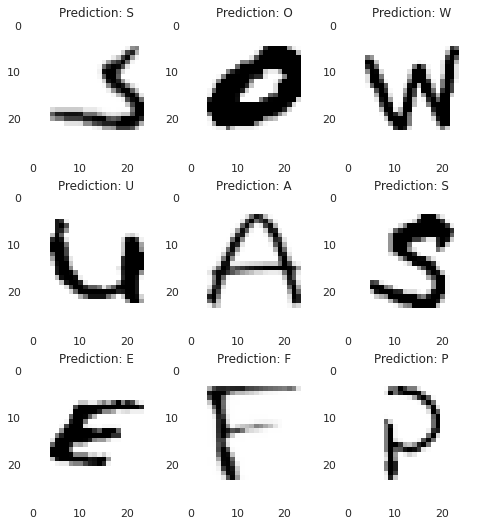

In [147]:
fig, axes = plt.subplots(3,3, figsize=(8,9))
axes = axes.flatten()

for i,ax in enumerate(axes):
    img = np.reshape(X_test[i], (28,28))
    ax.imshow(img, cmap="Greys")
    
    pred = word_dict[np.argmax(y_test[i])]
    ax.set_title("Prediction: "+pred)
    ax.grid()

## Analyzing Trends in Accuracy and AUC

In [148]:
print(f"Total number of epochs for which the model trained: {len(history.history['loss'])}")

Total number of epochs for which the model trained: 40


### Plotting Accuracy

Text(0, 0.5, 'Accuracy')

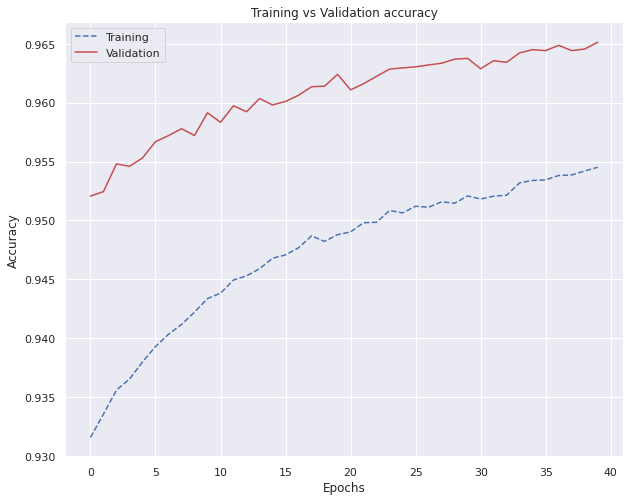

In [149]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(history.history['categorical_accuracy'], "b--")
plt.plot(history.history['val_categorical_accuracy'], "r-")
plt.title("Training vs Validation accuracy")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [150]:
print(f"Maximum Training Accuracy: {round(max(history.history['categorical_accuracy']),3)}, Maximum Validation Accuracy: {round(max(history.history['val_categorical_accuracy']),3)}")

Maximum Training Accuracy: 0.955, Maximum Validation Accuracy: 0.965


### Plotting AUC

Text(0, 0.5, 'AUC score')

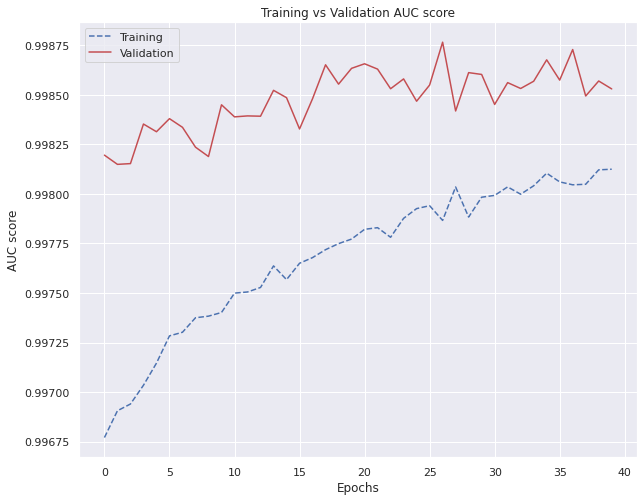

In [151]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(history.history['auc_2'], "b--")
plt.plot(history.history['val_auc_2'], "r-")
plt.title("Training vs Validation AUC score")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("AUC score")

In [131]:
history.history

{'loss': [0.9552961587905884,
  0.5434478521347046,
  0.4227047264575958,
  0.36408430337905884,
  0.32535606622695923,
  0.29964956641197205,
  0.27916857600212097,
  0.2660018801689148,
  0.2508319318294525,
  0.24312719702720642],
 'categorical_accuracy': [0.7192667126655579,
  0.8408308029174805,
  0.8755289316177368,
  0.894098699092865,
  0.9052888751029968,
  0.9126202464103699,
  0.918630838394165,
  0.9227620363235474,
  0.9268174171447754,
  0.9290174841880798],
 'auc_2': [0.9796980023384094,
  0.9909487366676331,
  0.9935142993927002,
  0.9943797588348389,
  0.9952535033226013,
  0.9955839514732361,
  0.9961220026016235,
  0.9962227940559387,
  0.9965068101882935,
  0.9966466426849365],
 'val_loss': [0.41881871223449707,
  0.3074532449245453,
  0.24935981631278992,
  0.225895494222641,
  0.20218230783939362,
  0.194248765707016,
  0.18112482130527496,
  0.17257249355316162,
  0.17083126306533813,
  0.16351436078548431],
 'val_categorical_accuracy': [0.8776390552520752,
  0.9

## Test Custom Image

In [155]:
img = cv2.imread(r'Digit_3.jpg')
img_copy = img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (400,440))

Convert image to BGR -

In [156]:
img_copy = cv2.GaussianBlur(img_copy, (7,7), 0)
img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
_, img_thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)

img_final = cv2.resize(img_thresh, (28,28))
img_final =np.reshape(img_final, (1,28,28,1))

Preprocessing -

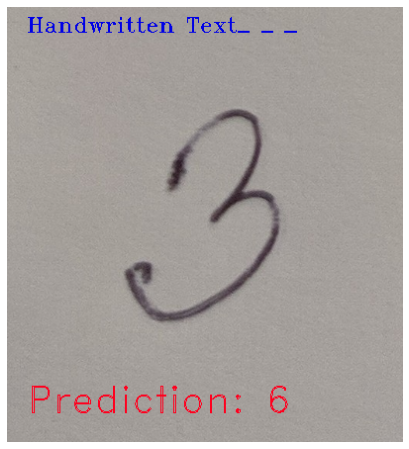

In [157]:
img_pred = word_dict[np.argmax(model.predict(img_final))]


cv2.putText(img, "Handwritten Text_ _ _ ", (20,25), cv2.FONT_HERSHEY_TRIPLEX, 0.7, color = (0,0,230))
cv2.putText(img, "Prediction: " + img_pred, (20,410), cv2.FONT_HERSHEY_DUPLEX, 1.3, color = (255,0,30))
#cv2.imshow('Dataflair handwritten character recognition _ _ _ ', img)

plt.imshow(img, cmap = "gray"), plt.axis("off")
plt.show()

# to not crush colab jupyter
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [105]:
img_pred

'A'

In [106]:
model.predict(img_final)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)